In [8]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt


Image 1 loaded: C:\Users\ASUS\OneDrive\Desktop\VR\pano\panorama\1.jpeg


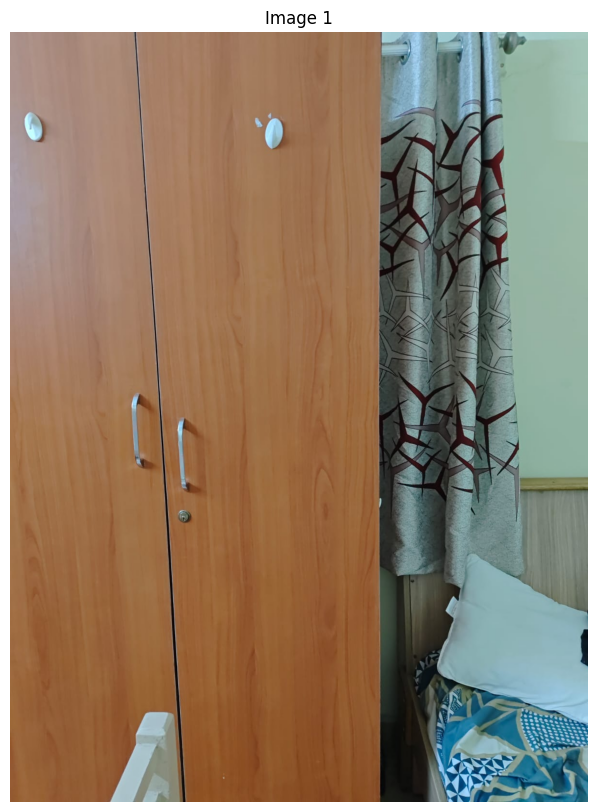

Image 2 loaded: C:\Users\ASUS\OneDrive\Desktop\VR\pano\panorama\2.jpeg


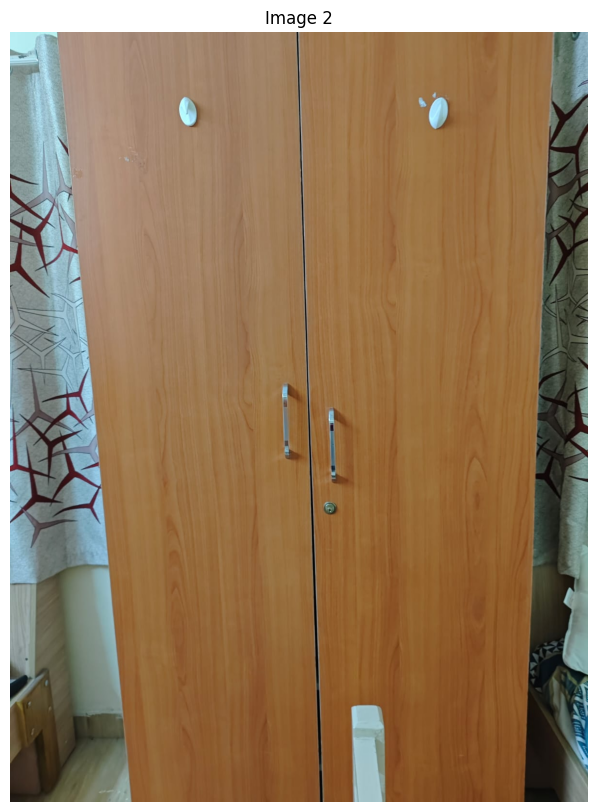

Image 3 loaded: C:\Users\ASUS\OneDrive\Desktop\VR\pano\panorama\3.jpeg


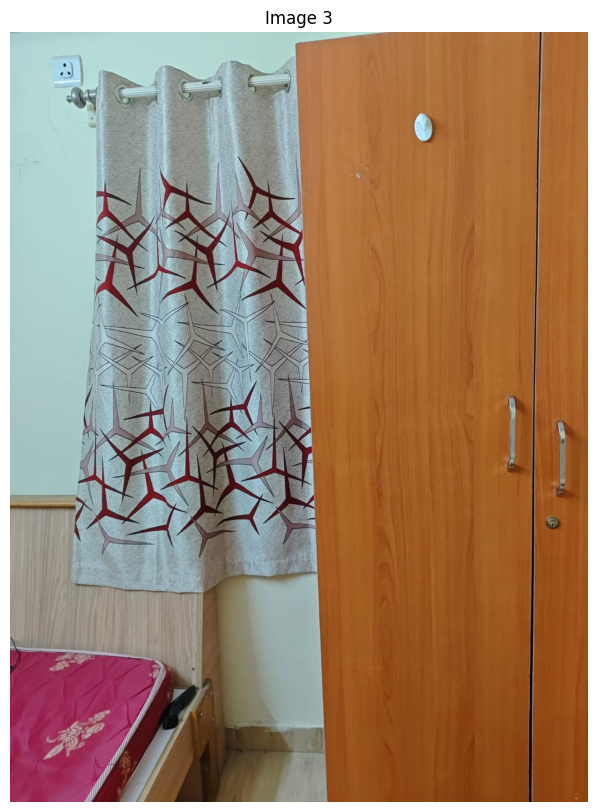

In [16]:
paths = glob.glob(r'C:\Users\ASUS\OneDrive\Desktop\VR\pano\panorama/*.jpeg')
imgs = [cv2.imread(p) for p in paths]
for idx, img in enumerate(imgs):
    if img is None:
        print(f"Error loading image at index {idx}: {paths[idx]}")
    else:
        print(f"Image {idx+1} loaded: {paths[idx]}")
        
        # Display the loaded image using plt
        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"Image {idx+1}")
        plt.axis('off')
        plt.show()

In [17]:
print(paths)


['C:\\Users\\ASUS\\OneDrive\\Desktop\\VR\\pano\\panorama\\1.jpeg', 'C:\\Users\\ASUS\\OneDrive\\Desktop\\VR\\pano\\panorama\\2.jpeg', 'C:\\Users\\ASUS\\OneDrive\\Desktop\\VR\\pano\\panorama\\3.jpeg']


Image 1 (C:\Users\ASUS\OneDrive\Desktop\VR\pano\panorama\1.jpeg): 3270 keypoints detected.
Image 2 (C:\Users\ASUS\OneDrive\Desktop\VR\pano\panorama\2.jpeg): 2038 keypoints detected.
Image 3 (C:\Users\ASUS\OneDrive\Desktop\VR\pano\panorama\3.jpeg): 3899 keypoints detected.


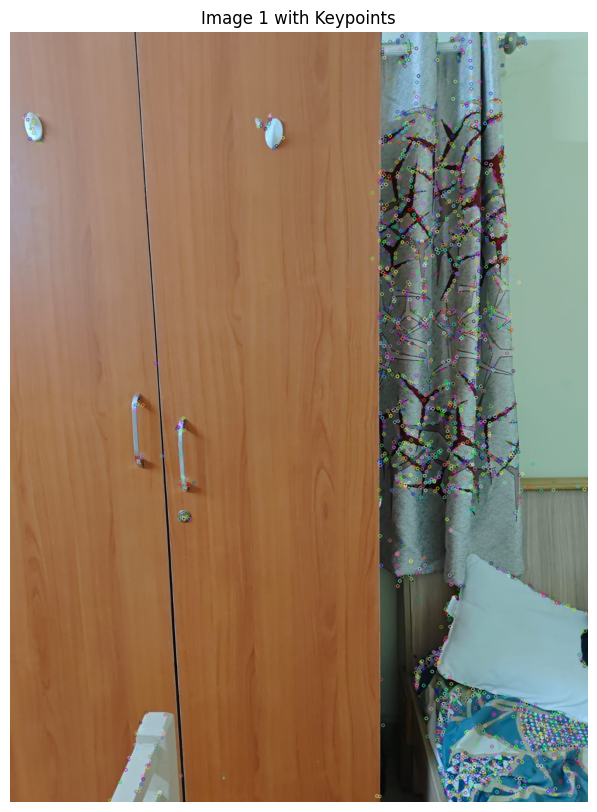

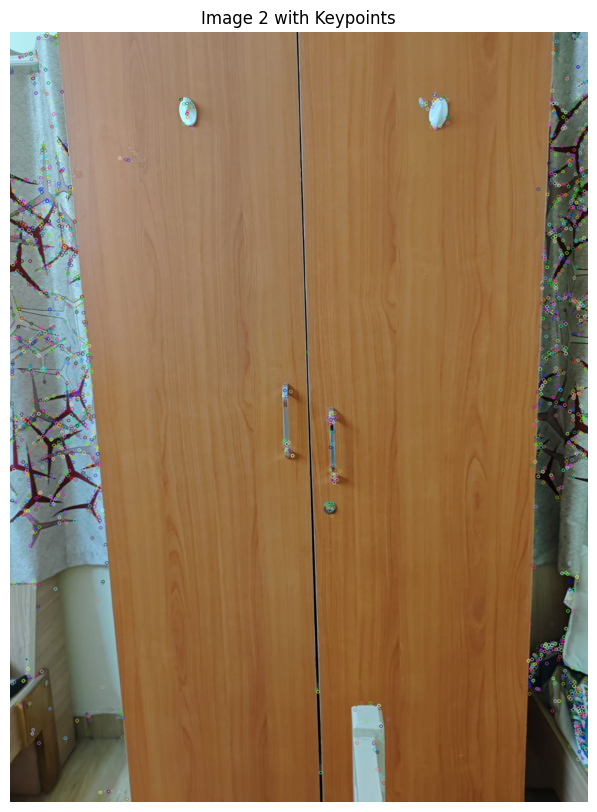

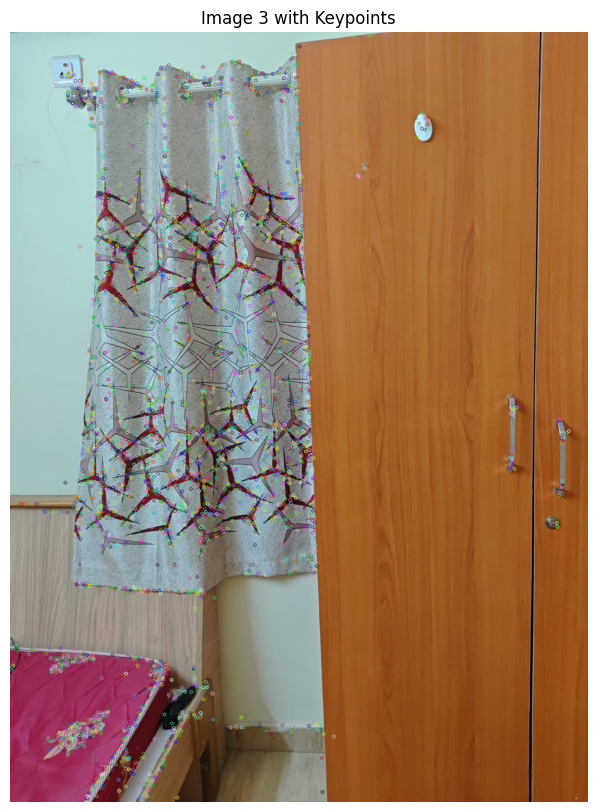

In [18]:
# Using SIFT feature detector
sift = cv2.SIFT_create()

# Prepare the BFMatcher
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

# Detecting and computing keypoints and descriptors for each of my image
kp_list = []
des_list = []
for i, img in enumerate(imgs):
    kp, des = sift.detectAndCompute(img, None)
    kp_list.append(kp)
    des_list.append(des)
    print(f"Image {i+1} ({paths[i]}): {len(kp)} keypoints detected.")

# Displaying keypoints for my images
for i, img in enumerate(imgs):
    img_kp = cv2.drawKeypoints(img, kp_list[i], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(img_kp, cv2.COLOR_BGR2RGB))
    plt.title(f"Image {i+1} with Keypoints")
    plt.axis('off')
    plt.show()


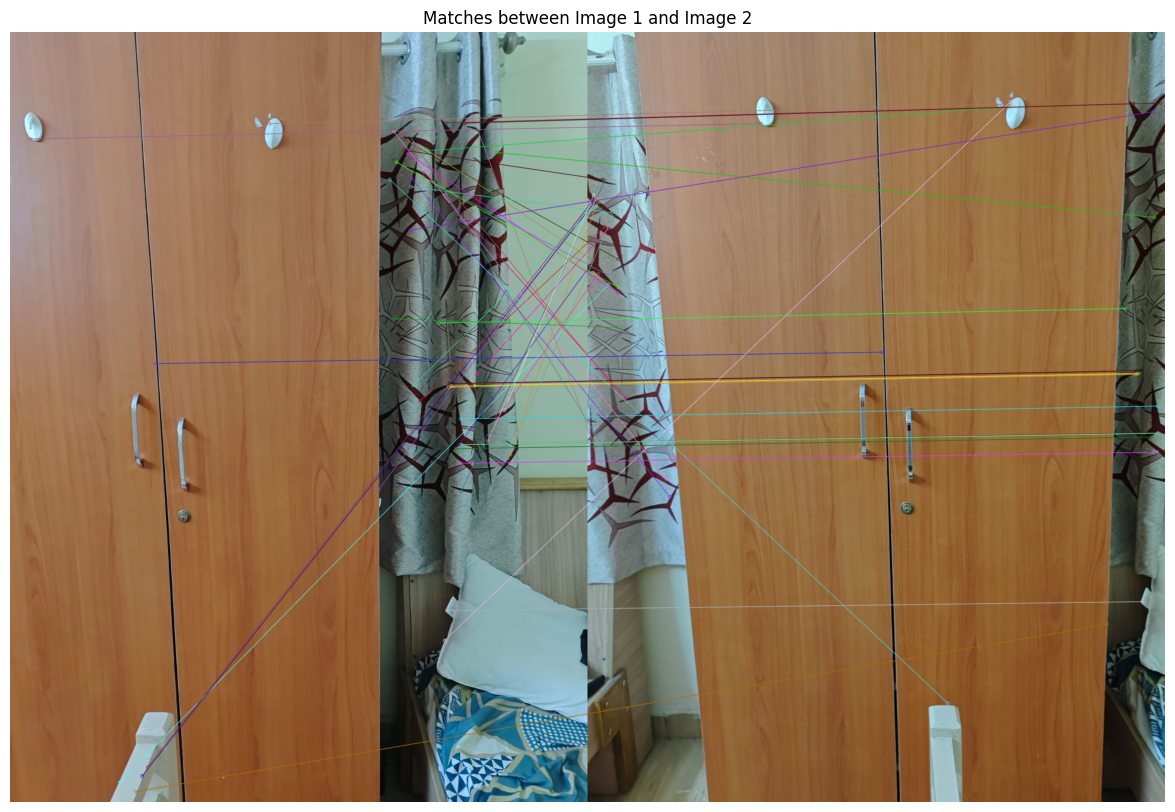

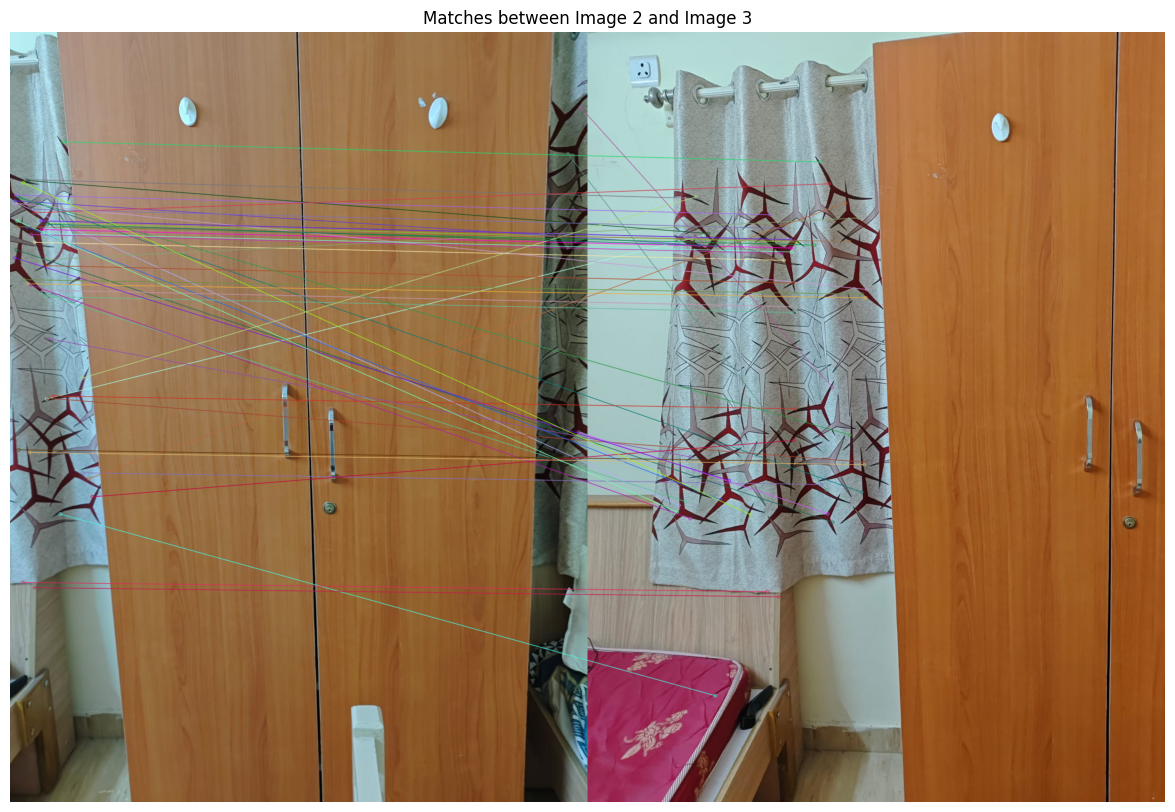

In [19]:
# Now matching descriptors between the images
matches_list = []
for i in range(len(imgs) - 1):
    # Now matching descriptors between consecutive images
    matches = bf.match(des_list[i], des_list[i+1])
    matches_list.append(matches)

    # OK now to sort them based on the distance (good matches are closer to each other)
    matches = sorted(matches, key = lambda x: x.distance)

    # Drawing the matches
    img_matches = cv2.drawMatches(imgs[i], kp_list[i], imgs[i+1], kp_list[i+1], matches[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    plt.figure(figsize=(15, 10))
    plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
    plt.title(f"Matches between Image {i+1} and Image {i+2}")
    plt.axis('off')
    plt.show()


[[ 4.71481724e-01  5.27880002e-03  3.19142468e+02]
 [-2.73133889e-01  6.61644286e-01  2.26265940e+02]
 [-3.74493562e-04 -4.76247642e-06  1.00000000e+00]]


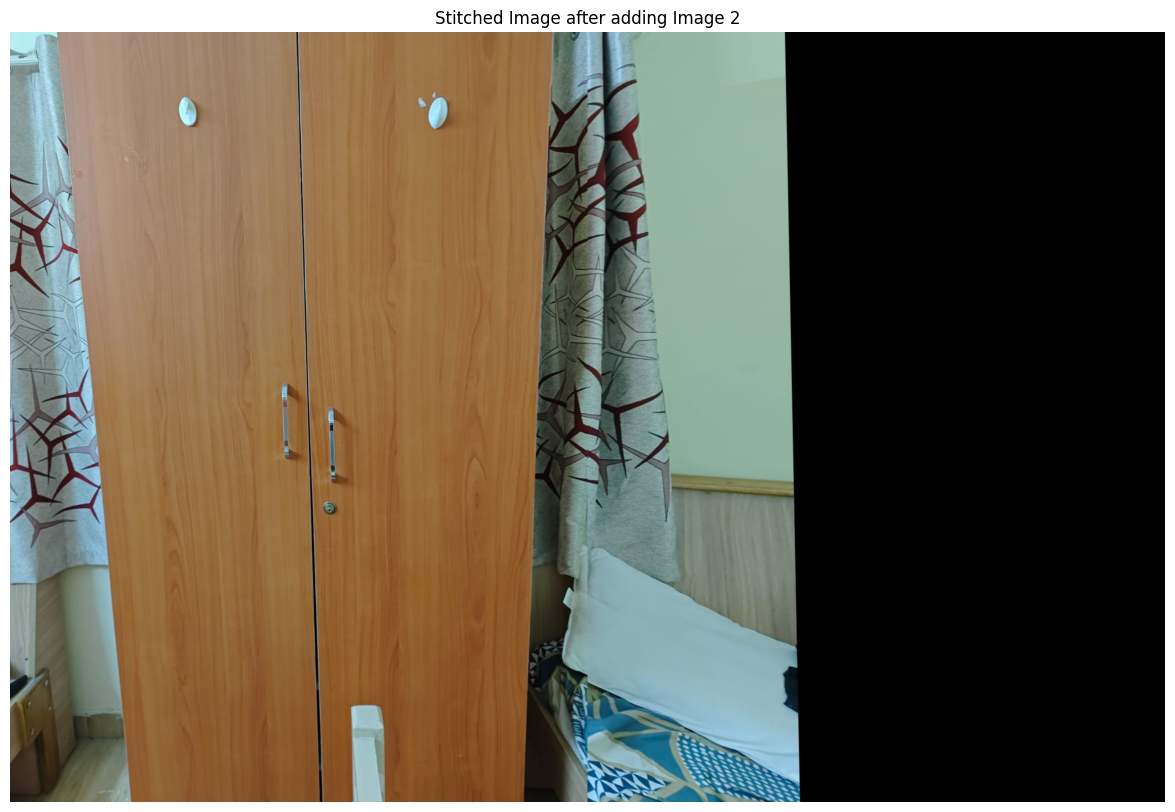

[[ 7.89310214e-01 -2.70052489e-02  3.78310178e+02]
 [-3.72983631e-02  9.47987075e-01  5.75668294e+01]
 [-4.43571444e-05 -1.45324734e-05  1.00000000e+00]]


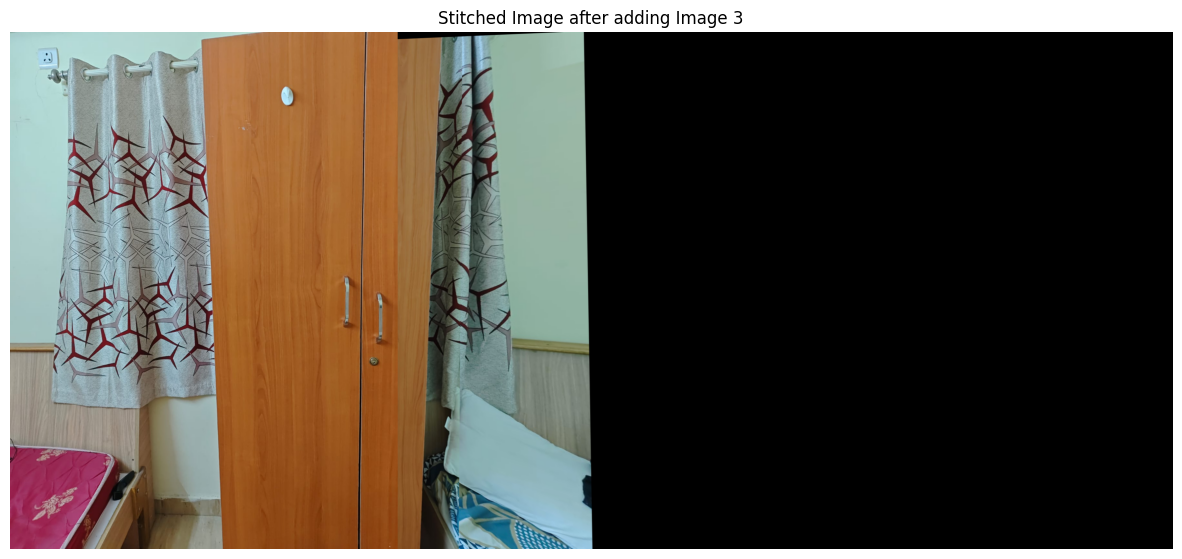

In [20]:
# Finding out the  Homography and using it ti stitch images together
result = imgs[0]
for i in range(1, len(imgs)):
    # Find Homography between result and next image
    matches = matches_list[i-1]
    src_pts = np.float32([kp_list[i-1][m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp_list[i][m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    # Computing  the homography matrix
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    print(H)

    # Warping the next image onto the result
    h, w = result.shape[:2]
    result = cv2.warpPerspective(result, H, (w + imgs[i].shape[1], h))
    result[0:imgs[i].shape[0], 0:imgs[i].shape[1]] = imgs[i]

    # Displaying intermediate result
    plt.figure(figsize=(15, 10))
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.title(f"Stitched Image after adding Image {i+1}")
    plt.axis('off')
    plt.show()


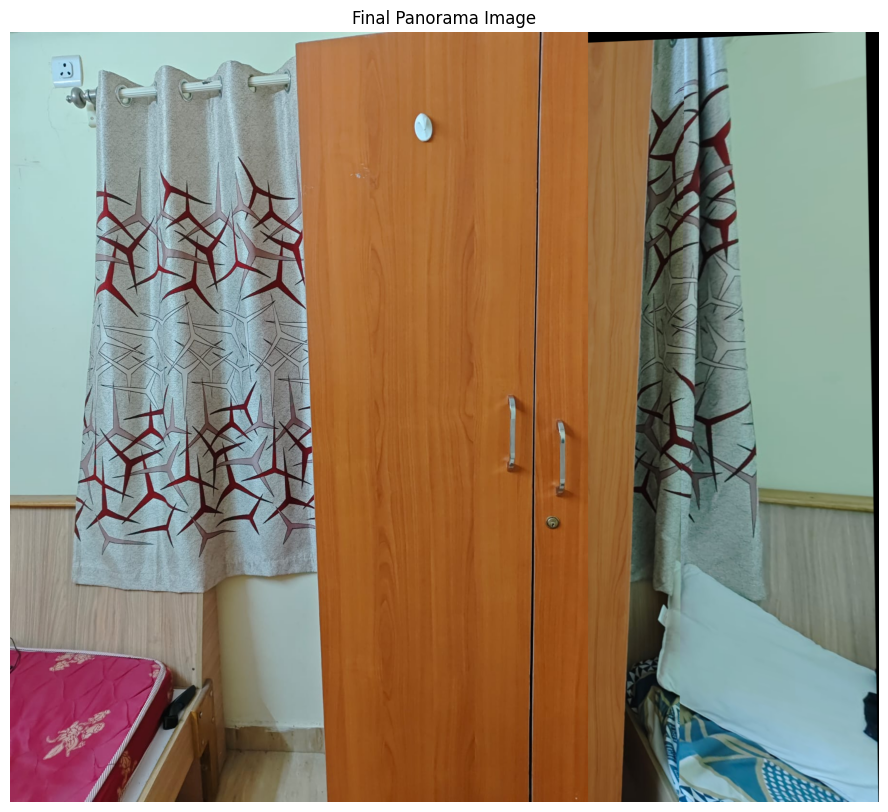

True

In [21]:
def crop_black_region(image):
    # Converting the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Thresholding the image to find black regions
    _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

    # Now finding the bounding box of the non-black region
    coords = cv2.findNonZero(thresh)
    x, y, w, h = cv2.boundingRect(coords)

    # Crop the image to the bounding box
    cropped_image = image[y:y+h, x:x+w]
    return cropped_image

# Applying cropping so as to remove black region
cropped_result = crop_black_region(result)

# Display the cropped result
plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(cropped_result, cv2.COLOR_BGR2RGB))
plt.title("Final Panorama Image")
plt.axis('off')
plt.show()
cv2.imwrite("panorama.jpg", cropped_result)
